<a href="https://colab.research.google.com/github/aminmed/EEG-epilepsySpikes-detection/blob/main/DWT_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyWavelets
!pip install antropy

     |████████████████████████████████| 49 kB 2.8 MB/s 
  Created wheel for antropy: filename=antropy-0.1.4-py3-none-any.whl size=16159 sha256=85fded86ae08a95204707603d26f0cf75819910b840108de0a5973600de3d598
  Stored in directory: /root/.cache/pip/wheels/d4/cc/6b/28fa7036bdabc6f1f92fd6a108ae259dbb48f107f676d6b491
Successfully built antropy


In [ ]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
import pywt
import antropy as ant


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# data loading from binary files 
data_train_neg = np.fromfile("drive/MyDrive/data-science/exp1-train-2000neg.bin", dtype=np.float32).reshape([2000,5,768])
data_train_pos = np.fromfile("drive/MyDrive/data-science/exp1-train-400pos.bin", dtype=np.float32).reshape([400,5,768])
data_test = np.fromfile("drive/MyDrive/data-science/exp12-test-1200.bin", dtype=np.float32).reshape([1200,5,768])


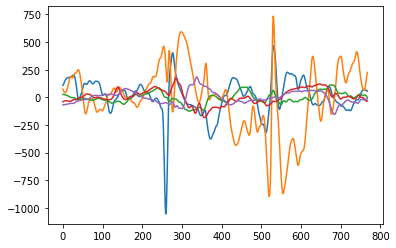

In [ ]:
t = np.arange(data_train_pos.shape[2])
plt.plot(t,data_train_pos[0,0],t,data_train_pos[0,1],t,
         data_train_pos[0,2],t,data_train_pos[0,3],t,data_train_pos[0,4])

In [ ]:
def extract_features(data):
  data = np.asarray(data)
  features  = [] 
  for channel in range(5):
      coeffs = pywt.wavedec(data[channel], 'db24', level=4)
      for coeff in range(5):
          features.append(min(coeffs[coeff])) 
          features.append(max(coeffs[coeff]))
          features.append(np.mean(coeffs[coeff])) 
          features.append(np.std(coeffs[coeff]))
          features.append(skew(coeffs[coeff]))
          features.append(kurtosis(coeffs[coeff]))
      features.append(skew(data[channel]))
      features.append(kurtosis(data[channel]))
      features.append(min(data[channel])) 
      features.append(max(data[channel]))
      features.append(np.mean(data[channel]))
      features.append(ant.katz_fd(data[channel]))
      features.append(ant.higuchi_fd(data[channel]))
      features.append(ant.perm_entropy(data[channel]))
      
      features.append(np.sqrt(np.sum(np.power(data[channel], 2)) / data.shape[0]))
  return np.asarray(features)


In [ ]:
ts_data = np.concatenate((data_train_neg,data_train_pos),axis = 0)
print(ts_data.shape)
nb_features = 195

(2400, 5, 768)


In [ ]:
data_features = []
for i in range(ts_data.shape[0]):
    features = extract_features(ts_data[i,:])
    data_features.append(features)
data_features = np.asarray(data_features)
data_features = data_features.reshape((ts_data.shape[0],nb_features))
print(data_features.shape)

(2400, 195)


In [ ]:
from sklearn import preprocessing
X = data_features
Y = np.concatenate((np.zeros(data_train_neg.shape[0]),np.ones(data_train_pos.shape[0])), axis = 0)
Y = Y.reshape((Y.shape[0],))

# normalize features
X = preprocessing.normalize(X)

In [ ]:
from sklearn.model_selection import train_test_split, KFold

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=0)
print('The number of samples for the non-seizure class in training is:', y_train.shape[0])
print('The number of samples for the seizure class in training is:', np.sum(y_train))
print('The number of samples for the non-seizure class in testing is:', y_test.shape[0])
print('The number of samples for the seizure class in testing is:', np.sum(y_test))

The number of samples for the non-seizure class in training is: 1680
The number of samples for the seizure class in training is: 291.0
The number of samples for the non-seizure class in testing is: 720
The number of samples for the seizure class in testing is: 109.0


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import time

model = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
      beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(12, 12,12), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
      nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
      verbose=False, warm_start=False)

#model = AdaBoostClassifier(random_state=0)

kf = KFold(n_splits=5)
accuracy, TPR, FPR = [], [], []
for train, test in kf.split(X_train):
    model.fit(X_train[train, :], y_train[train])
    pred = model.predict(X_train[test])
    tn, fp, fn, tp = confusion_matrix(y_train[test], pred).ravel()
    accuracy.append((tp + tn)/(tn + fp + fn + tp))
    TPR.append(tp / (tp + fn))
    FPR.append(fp / (fp + tn))
# hold our validation
start = time.time()
model.fit(X_train, y_train)
pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
test_accuracy = ((tp + tn)/(tn + fp + fn + tp))
test_TPR = (tp / (tp + fn))
test_FPR = (fp / (fp + tn))
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
print(confusion_matrix(y_test, pred))


00:00:03.51
[[597  14]
 [ 19  90]]


In [ ]:
test_features = []
for i in range(data_test.shape[0]):
    features = extract_features(data_test[i,:])
    test_features.append(features)
test_features = np.asarray(test_features)
test_features = test_features.reshape((data_test.shape[0],nb_features))
print(test_features.shape)

(1200, 195)


In [ ]:
X_test_ = preprocessing.normalize(test_features) 
Y_test_ = model.predict(X_test_)

In [ ]:
import csv 
with open('./result-12-12-6-195.txt','w',newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['Outcome','Id'])
  for i in range(X_test_.shape[0]):
      writer.writerow([int(Y_test_[i]),i])


In [ ]:
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score

D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

# eta typically between 0.1 and 0.3, similar to learning rate
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 2} 

steps = 20  # The number of training iterations
model = xgb.train(param, D_train, steps)

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))


Precision = 0.9366172805317086
Recall = 0.878774456072914
Accuracy = 0.9541666666666667


In [ ]:
D_test_ = xgb.DMatrix(X_test_)
preds = model.predict(D_test_)
preds_ = np.asarray([np.argmax(line) for line in preds])

In [ ]:
import csv 
with open('./result-xgb.txt','w',newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['Outcome','Id'])
  for i in range(X_test_.shape[0]):
      writer.writerow([int(preds_[i]),i])


In [ ]:
import pandas as pd
xgb_y = pd.read_csv('result-xgb.txt')
ada_y = pd.read_csv('result-ada.txt')
mlp_y = pd.read_csv('result.txt')
with open('./result-group.txt','w',newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['Outcome','Id'])
  for i in range(X_test_.shape[0]):
  
      if( (xgb_y.iloc[i,0] + mlp_y.iloc[i,0] + ada_y.iloc[i,0]) >=2):
          writer.writerow([1,i])
      else:
          writer.writerow([0,i])

In [ ]:
#model = AdaBoostClassifier(random_state=0)

kf = KFold(n_splits=5)
accuracy, TPR, FPR = [], [], []
for train, test in kf.split(X_train):
    model.fit(X_train[train, :], y_train[train])
    pred = model.predict(X_train[test])
    tn, fp, fn, tp = confusion_matrix(y_train[test], pred).ravel()
    accuracy.append((tp + tn)/(tn + fp + fn + tp))
    TPR.append(tp / (tp + fn))
    FPR.append(fp / (fp + tn))
# hold our validation
start = time.time()
model.fit(X_train, y_train)
pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
test_accuracy = ((tp + tn)/(tn + fp + fn + tp))
test_TPR = (tp / (tp + fn))
test_FPR = (fp / (fp + tn))
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
print(confusion_matrix(y_test, pred))